In [27]:
import dataclasses
import os
from tqdm.auto import tqdm
from gtp.options.calculate_epistasis import CalculateEpistasisOptions
from gtp.configs.loaders import load_configs
from gtp.configs.project import GenotypeToPhenotypeConfigs

from gtp.dataloading.path_collectors import (
    get_post_processed_genotype_directory,
    get_results_training_output_directory,
)

from gtp.tools.simple import create_exp_info_text

In [28]:
import numpy as np
from gtp.dataloading.tools import load_json, collect_chromosome_position_metadata
from gtp.dataloading.data_collectors import load_chromosome_and_phenotype_data

def collect_chromosome_attributions(
    configs: GenotypeToPhenotypeConfigs, options: CalculateEpistasisOptions, chromosome: int
):
    options = dataclasses.replace(options)
    options.chromosome = chromosome

    training_output_dir = get_results_training_output_directory(configs.io)
    exp_info = create_exp_info_text(
        species=options.species,
        wing=options.wing,
        color=options.color,
        chromosome=options.chromosome,
    )

    experiment_dir = training_output_dir / options.exp_name / exp_info
    if not os.path.exists(experiment_dir):
        print(
            f"{experiment_dir} does not exist. Unable to process chromosome {options.chromosome}"
        )
        return

    # Load attributions
    train_attributions = np.load(experiment_dir / "training_attributions.npy")
    val_attributions = np.load(experiment_dir / "validation_attributions.npy")
    test_attributions = np.load(experiment_dir / "test_attributions.npy")
    train_metrics = load_json(experiment_dir / "training_metrics.json")
    val_metrics = load_json(experiment_dir / "validation_metrics.json")
    test_metrics = load_json(experiment_dir / "test_metrics.json")

    # Get Chromosome metadata
    genotype_folder = get_post_processed_genotype_directory(configs.io)

    position_metadata = collect_chromosome_position_metadata(
        genotype_folder / configs.experiment.genotype_scope,
        options.species,
        options.chromosome,
    )

    assert (
        len(position_metadata)
        == train_attributions.shape[0]
        == val_attributions.shape[0]
        == test_attributions.shape[0]
    ), "Must have matching length to be accurate."

    # Creating metadata values [[{idx}, {CHROMOSOME}, '{SCAFFOLD}:{SCAFFOLD_POSITION}"], ...]
    metadata = [
        [i, int(options.chromosome), f"{x[0]}:{x[1]}"]
        for i, x in enumerate(position_metadata)
    ]
    
    return metadata, train_attributions, val_attributions, test_attributions

def collect_chromosome_data(
    configs: GenotypeToPhenotypeConfigs, options: CalculateEpistasisOptions, chromosome: int
):
    options = dataclasses.replace(options)
    options.chromosome = chromosome
    
    camids_aligned, genotype_data_aligned, phenotype_data_aligned = load_chromosome_and_phenotype_data(configs, options)
    
    return camids_aligned, genotype_data_aligned, phenotype_data_aligned

In [29]:
import pandas as pd
from gtp.tools.epistasis import detect_epistasis_imm

def calculate_epistasis(
    configs: GenotypeToPhenotypeConfigs, options: CalculateEpistasisOptions
):
    all_X = None
    all_y = None
    all_metadata = []
    all_camids = None
    for chromosome in tqdm(
        range(1, configs.global_butterfly_metadata.number_of_chromosomes + 1),
        desc="Processing Chromosomes",
        colour="blue",
    ):
        metadata, train_atts, val_atts, test_atts = collect_chromosome_attributions(configs=configs, options=options, chromosome=chromosome)
        camids_aligned, genotype_data_aligned, phenotype_data_aligned = collect_chromosome_data(configs=configs, options=options, chromosome=chromosome)
        
        if all_camids is not None:
            assert (all_camids == camids_aligned).all(), "CAM IDs must be aligned"
        else:
            all_camids = camids_aligned
        
        # Grab attribution values based on the testing data
        if options.filter_value == "attribution":
            value_idx = 0
        elif options.filter_value == "pcc":
            value_idx = 1
        elif options.filter_value == "pvalue":
            value_idx = 2
        else:
            raise NotImplementedError(f"{options.filter_value} is not a valid filter value please select from [attribution, pcc, pvalue]")
            
        test_values = test_atts[:, value_idx] # We select from the test values for the top k snps
        sorted_idx = np.argsort(test_values)
        if value_idx < 2: # attribution, pcc
            sorted_idx = sorted_idx[::-1]
        
        # TODO: combine all chromosomes together into a valid dataframe
        
        # Combine all phases of data
        

        # convert 1-hot to value
        X = (genotype_data_aligned[:, sorted_idx[:options.top_k]] * [0, 1, 2]).sum(-1)
        y = phenotype_data_aligned[:, 0]
        
        # Filter metadata by top values
        filtered_metadata = [metadata[i] for i in sorted_idx[:options.top_k]]
        all_metadata.extend(filtered_metadata)

        X = pd.DataFrame(X, columns=[f"{chromosome}:{idx}" for idx in sorted_idx[:50]])
        y = pd.DataFrame(y, columns=["phenotype"]).iloc[:, -1]
        
        if all_y is not None:
            assert (all_y == y).all(), "Phenotypes must match regardless of which chromosome they loaded from."
        else:
            all_y = y
            
        if all_X is not None:
            all_X = pd.concat((all_X, X), axis=1)
        else:
            all_X = X

    epistasis_results = detect_epistasis_imm(data=all_X, phenotype=all_y, alpha=options.alpha)
        
        
    
    return epistasis_results

In [30]:
def calculate_all_epistasis_interactions(
    configs: GenotypeToPhenotypeConfigs, options: CalculateEpistasisOptions
):
    options = dataclasses.replace(options)

    for species in configs.global_butterfly_metadata.species:
        for wing in configs.global_butterfly_metadata.wings:
            for color in configs.global_butterfly_metadata.phenotypes:
                options.species = species
                options.wing = wing
                options.color = color
                print(f"Processing Options: {options}")
                calculate_epistasis(configs=configs, options=options)

In [ ]:
from pathlib import Path

cfgs: GenotypeToPhenotypeConfigs = load_configs(config_path=Path("../../configs/default.yaml"))
opts: CalculateEpistasisOptions = CalculateEpistasisOptions(
    out_dims = 1,
    out_dims_start_idx = 0,
    species = "erato",
    color = "color_3",
    wing = "forewings",
    exp_name = "base",
    verbose = False,
    process_all = False,
    filter_value = "attribution",
    top_k = 50,
    alpha = 0.05,
)

if opts.process_all:
    results = calculate_all_epistasis_interactions(configs=cfgs, options=opts)
else:
    results = calculate_epistasis(configs=cfgs, options=opts)


Processing Chromosomes:   0%|          | 0/21 [00:00<?, ?it/s]

NameError: name 'alpha' is not defined

In [6]:
import pandas as pd
from gtp.tools.epistasis import detect_epistasis_imm

metadata, train_atts, val_atts, test_atts, train_data, val_data, test_data = results

# Grab attribution values based on the testing data
value_idx = 0 # 0 - "attribution", 1 - "pcc", 2 - "pvalue"
test_values = test_atts[:, value_idx]
sorted_idx = np.argsort(test_values)
if value_idx < 2: # attribution, pcc
    sorted_idx = sorted_idx[::-1]
    
# Combine all phases of data
X = np.concatenate((train_data[0], val_data[0], test_data[0]), axis=0)
y = np.concatenate((train_data[1], val_data[1], test_data[1]), axis=0)

fo_results = {}
alpha = 0.05

# convert 1-hot to value
X = (X[:, sorted_idx[:50]] * [0, 1, 2]).sum(-1)
y = y[:, 0]

X = pd.DataFrame(X, columns=[f"{idx}" for idx in sorted_idx[:50]])
y = pd.DataFrame(y, columns=["phenotype"]).iloc[:, -1]

epistasis_results = detect_epistasis_imm(data=X, phenotype=y, alpha=alpha)

/home/carlyn.1/dna-trait-analysis/src/gtp/tools/epistasis.py:45: RuntimeWarning: invalid value encountered in scalar divide
  v = v - ((interaction_vector_tilde.dot(q2)/q2.dot(q2))*q2)
/home/carlyn.1/dna-trait-analysis/src/gtp/tools/epistasis.py:51: RuntimeWarning: invalid value encountered in scalar divide
  residual = residual - (phenotype_tilde.dot(q2)/q2.dot(q2))*q2
/home/carlyn.1/dna-trait-analysis/src/gtp/tools/epistasis.py:42: RuntimeWarning: invalid value encountered in scalar divide
  x = (snp1_tilde.dot(interaction_vector_tilde)/snp1_tilde.dot(snp1_tilde)) * (snp1_tilde) # 2nd term in the v variable, using to breakdown the formula
/home/carlyn.1/dna-trait-analysis/src/gtp/tools/epistasis.py:44: RuntimeWarning: invalid value encountered in scalar divide
  q2 = snp2_tilde - (((snp1_tilde.dot(snp2_tilde)) / (snp1_tilde.dot(snp1_tilde))) * snp1_tilde)
/home/carlyn.1/dna-trait-analysis/src/gtp/tools/epistasis.py:50: RuntimeWarning: invalid value encountered in scalar divide
  resi

In [7]:
from typing import List
from dataclasses import dataclass
import statsmodels.api as sma

@dataclass(kw_only=True)
class OLS_Output:
    results: sma.regression.linear_model.RegressionResults
    pvalues: List[float]
    tvalues: List[float]
    f_pvalue: float
    fvalue: float
    rsquared: float
    rsquared_adj: float
    train_rmse: float
    val_rmse: float
    test_rmse: float
    
def run_ols(X_tr, X_val, X_test, y_tr, y_val, y_test):
    X_in = sma.add_constant(X_tr)
    m = sma.OLS(y_tr, X_in)
    m2 = m.fit()
    
    train_predictions = m2.predict(X_in)
    train_rmse = np.sqrt(((train_predictions - y_tr) ** 2).sum() / (len(train_predictions)-2))
    
    Xv_in = sma.add_constant(X_val)
    val_predictions = m2.predict(Xv_in)
    val_rmse = np.sqrt(((val_predictions - y_val) ** 2).sum() / (len(val_predictions)-2))
    
    X_test_in = sma.add_constant(X_test)
    test_predictions = m2.predict(X_test_in)
    test_rmse = np.sqrt(((test_predictions - y_test) ** 2).sum() / (len(test_predictions)-2))
    
    return OLS_Output(
        results = m2,
        pvalues = m2.pvalues,
        tvalues = m2.tvalues,
        f_pvalue = m2.f_pvalue,
        fvalue = m2.fvalue,
        rsquared = m2.rsquared,
        rsquared_adj = m2.rsquared_adj,
        train_rmse = train_rmse,
        val_rmse = val_rmse,
        test_rmse = test_rmse,
    )
        

In [8]:
metadata, train_atts, val_atts, test_atts, train_data, val_data, test_data = results

value_idx = 0 # 0 - "attribution", 1 - "pcc", 2 - "pvalue"
test_values = test_atts[:, value_idx]
sorted_idx = np.argsort(test_values)
if value_idx < 2: # attribution, pcc
    sorted_idx = sorted_idx[::-1]

fo_results = {}
for idx in sorted_idx[:50]:
    # convert 1-hot to value
    X_tr = (train_data[0][:, idx] * [0, 1, 2]).sum(-1)
    X_val = (val_data[0][:, idx] * [0, 1, 2]).sum(-1)
    X_test = (test_data[0][:, idx] * [0, 1, 2]).sum(-1)
    
    y_tr = train_data[1][:, 0]
    y_val = val_data[1][:, 0]
    y_test = test_data[1][:, 0]
    
    result = run_ols(X_tr, X_val, X_test, y_tr, y_val, y_test)
    fo_results[idx] = result


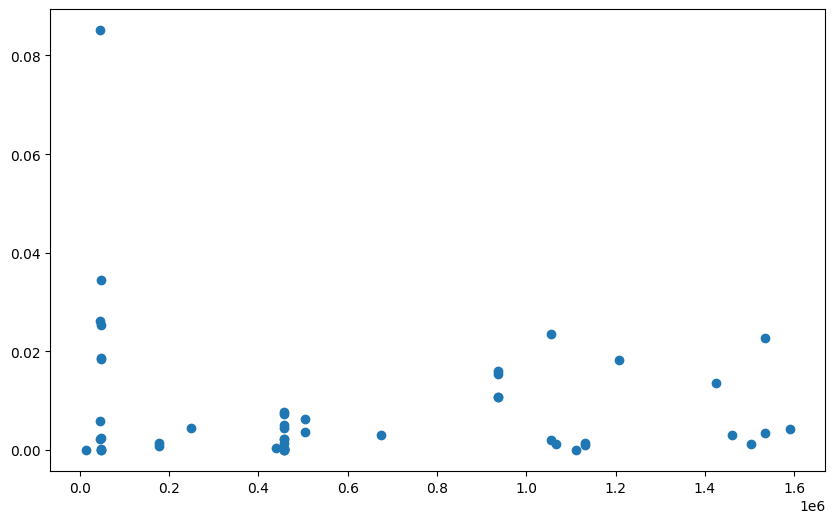

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

pvalues = [x.pvalues[-1] for x in fo_results.values()]
neg_log_values = [-np.log10(x) if not np.isnan(x) else 0 for x in pvalues]
r2_values = [x.rsquared for x in fo_results.values()]
ax.scatter(list(fo_results.keys()), r2_values)
plt.show()


In [10]:
import itertools as it

interactions = list(it.combinations(sorted_idx[:50], 2))
so_results = {}
for i1, i2 in interactions:
    X_tr = np.concatenate(((train_data[0][:, i1] * [0, 1, 2]).sum(-1)[:, np.newaxis], (train_data[0][:, i2] * [0, 1, 2]).sum(-1)[:, np.newaxis]), axis=1)
    X_val = np.concatenate(((val_data[0][:, i1] * [0, 1, 2]).sum(-1)[:, np.newaxis], (val_data[0][:, i2] * [0, 1, 2]).sum(-1)[:, np.newaxis]), axis=1)
    X_test = np.concatenate(((test_data[0][:, i1] * [0, 1, 2]).sum(-1)[:, np.newaxis], (test_data[0][:, i2] * [0, 1, 2]).sum(-1)[:, np.newaxis]), axis=1)
    
    y_tr = train_data[1][:, 0]
    y_val = val_data[1][:, 0]
    y_test = test_data[1][:, 0]
    
    result = run_ols(X_tr, X_val, X_test, y_tr, y_val, y_test)
    so_results[(i1, i2)] = result
    print(so_results[(i1, i2)].results.summary())

/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.002257
Date:                Tue, 04 Feb 2025   Prob (F-statistic):              0.962
Time:                        16:54:53   Log-Likelihood:                -1820.8
No. Observations:                 384   AIC:                             3646.
Df Residuals:                     382   BIC:                             3653.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0619      1.716     -0.036      0.9

/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scala

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5878
Date:                Tue, 04 Feb 2025   Prob (F-statistic):              0.444
Time:                        16:54:53   Log-Likelihood:                -1820.5
No. Observations:                 384   AIC:                             3645.
Df Residuals:                     382   BIC:                             3653.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3970      1.502     -0.264      0.7

/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.479
Date:                Tue, 04 Feb 2025   Prob (F-statistic):             0.0318
Time:                        16:54:54   Log-Likelihood:                -1817.3
No. Observations:                 384   AIC:                             3641.
Df Residuals:                     381   BIC:                             3652.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5126      2.518     -2.189      0.0

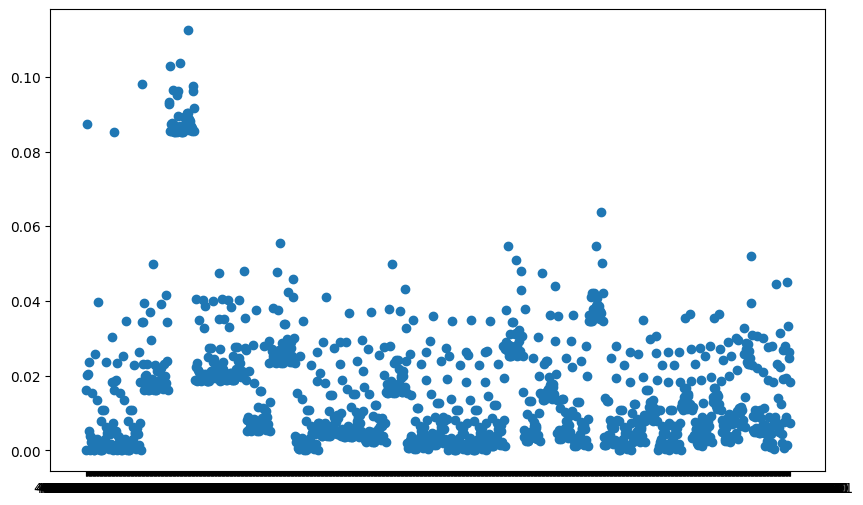

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

rsquared_values = [x.rsquared for x in so_results.values()]
x = [f"{i1}-{i2}" for i1, i2 in so_results.keys()]
#neg_log_values = [-np.log10(x) if not np.isnan(x) else 0 for x in pvalues]
ax.scatter(x, rsquared_values)
plt.show()

In [12]:
print(f"Length of metadata: {len(metadata)}")
print(f"att shape: {train_atts.shape}")
print(f"data shape: {train_data[0].shape}")

Length of metadata: 1646818
att shape: (1646818, 3)
data shape: (384, 1646818, 3)
